# QUANTITATIVE TRADING STRATEGIES - HW 3

## Financial Ratio Quantile Strategies

**Name**: Adriana Mata

**Date**: 01/02/2024

# 1. Introduction



# 2. Data Manipulation

## 2.1. Data Extraction

The data extraction process involves retrieving financial data from NASDAQ Quandl. This extraction was done using the University of Chicago email account, which provides students with access to a wide variety of data sources and datasets for analysis.

Before starting the data extraction, it is necessary to ensure that the required libraries are imported into the Jupyter Notebook file. These libraries, such as Pandas, NumPy, Matplotlib, among others, will be very useful to reduce the length of the code and make tasks more efficient.

In [796]:
import os
import datetime
import quandl
import config

import pandas as pd
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq
import itertools
import seaborn as sns

import requests
from io import StringIO

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize

import scipy.stats as stats
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings("ignore")

The ``grab_quandl_table`` function is responsible for handling the download of data tables from Quandl. This function has been designed to avoid downloading the same data repeatedly. Hence, it will only grab new data once per day; otherwise, it will use the data from the file cache.

For this function to work, we need to specify the Quandl table path, the path to the directory where we want to store the downloaded data, and the private API Key, which is provided when you create your account on Quandl. If the download is successful and there's no date override, the function creates a symlink to the downloaded file.

In [797]:
path = os.getcwd()

def grab_quandl_table(table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(path, "quandl_data_table_downloads") # Change this to your own directory
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs # Private API key
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )



This function wraps around the previously defined `grab_quandl_table` to fetch and return a Pandas DataFrame. It reads the downloaded data file into a DataFrame and returns it for further analysis.

In this case, all data regarding ‘QUOTEMEDIA/PRICES’ has been downloaded. This data contains multiple tickers, prices and volume trades for multiple dates. This data will be sorted and cleaned in the upcoming steps.

In [798]:
prices = fetch_quandl_table('QUOTEMEDIA/PRICES')
prices.head()

Skipping any possible download of QUOTEMEDIA/PRICES


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,JTKWY,2022-03-11,6.1700,7.3200,5.790,6.72,9440097.0,0.0,1.0,6.1700,7.3200,5.790,6.72,9440097.0
1,JTKWY,2022-03-10,6.1600,6.1750,5.935,6.07,2261623.0,0.0,1.0,6.1600,6.1750,5.935,6.07,2261623.0
2,FG_1,2020-06-01,8.1000,8.3900,8.100,8.39,3086317.0,0.0,1.0,8.1000,8.3900,8.100,8.39,3086317.0
3,FLWS,2022-03-09,14.5700,14.9588,14.410,14.45,662492.0,0.0,1.0,14.5700,14.9588,14.410,14.45,662492.0
4,RENW_,2020-01-29,21.9768,21.9900,21.970,21.99,319.0,0.0,1.0,21.9768,21.9900,21.970,21.99,319.0


The following `FC` table contains over 200 fundamental indicators for over 19,500 companies including over 10,000 delisted stocks.

In [799]:
FC = fetch_quandl_table('ZACKS/FC')
FC.head()

Skipping any possible download of ZACKS/FC


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_end_date,per_type,per_code,per_fisc_year,...,stock_based_compsn_qd,cash_flow_oper_activity_qd,net_change_prop_plant_equip_qd,comm_stock_div_paid_qd,pref_stock_div_paid_qd,tot_comm_pref_stock_div_qd,wavg_shares_out,wavg_shares_out_diluted,eps_basic_net,eps_diluted_net
0,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2006-12-31,A,NaN,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2007-12-31,A,NaN,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2008-12-31,A,NaN,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2009-12-31,A,NaN,2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2010-12-31,A,NaN,2010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `FR` table contains 26 fundamental ratios for over 19,500 companies, including over 10,000 delisted stocks.

In [800]:
FR = fetch_quandl_table('ZACKS/FR')
FR.head()

Skipping any possible download of ZACKS/FR


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_end_date,per_type,per_code,per_fisc_year,...,invty_turn,rcv_turn,day_sale_rcv,ret_equity,ret_tang_equity,ret_asset,ret_invst,free_cash_flow_per_share,book_val_per_share,oper_cash_flow_per_share
0,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2006-12-31,A,NaN,2006,...,NaN,NaN,NaN,2.4085,1.3277,0.7184,2.3844,NaN,NaN,NaN
1,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2007-12-31,A,NaN,2007,...,NaN,NaN,NaN,-0.2536,-0.1624,-0.0851,-0.2411,NaN,NaN,NaN
2,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2008-12-31,A,NaN,2008,...,NaN,NaN,NaN,-0.1566,-0.0905,-0.0507,-0.1497,NaN,NaN,NaN
3,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2009-12-31,A,NaN,2009,...,NaN,NaN,NaN,-0.2429,-0.1426,-0.0778,-0.2328,NaN,NaN,NaN
4,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2010-12-31,A,NaN,2010,...,NaN,NaN,NaN,-0.0653,-0.0375,-0.0209,-0.0627,NaN,NaN,NaN


The `master` table contains descriptive information about all tickers that are included in Zacks products.

In [801]:
master = fetch_quandl_table('ZACKS/MT')
master.head()

Skipping any possible download of ZACKS/MT


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,ticker_type,active_ticker_flag,comp_url,sic_4_code,...,per_end_month_nbr,mr_split_date,mr_split_factor,comp_cik,country_code,country_name,comp_type,optionable_flag,sp500_member_flag,asset_type
0,Z86Z,0425B,NaN,PCA INTL,NaN,NaN,NaN,N,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FFFC,1186Q,NaN,FRANKLIN FIRST,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WSTF,1197Q,NaN,WESTERN FINL CP,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HBCI,1209Q,NaN,HARMONIA,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TONE,1352Q,NaN,ONE BCP,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `mkt_val` table contains supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value. Market cap is the total value of all of a company's outstanding stock. You calculate it by multiplying the current stock price by the number of shares owned by stockholders.


In [802]:
mkt_val = fetch_quandl_table('ZACKS/MKTV')
mkt_val.head()


Skipping any possible download of ZACKS/MKTV


,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,mkt_val,ep_val
0,A,A2,AGILENT TECH,10,Q,2023-09-30,Y,32717.11,34122.11
1,A,A2,AGILENT TECH,10,Q,2023-06-30,Y,35518.94,37076.94
2,A,A2,AGILENT TECH,10,Q,2023-03-31,Y,40907.39,42390.39
3,A,A2,AGILENT TECH,10,Q,2022-12-31,Y,44275.46,45955.46
4,A,A2,AGILENT TECH,10,Q,2022-09-30,Y,35983.73,37638.73


The `shares` table contains supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. Shares outstanding are the total number of shares issued by a corporation.

In [803]:
shares = fetch_quandl_table('ZACKS/SHRS')
shares.head()

Skipping any possible download of ZACKS/SHRS


,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,shares_out,avg_d_shares
0,A,A2,AGILENT TECH,10,Q,2023-07-31,Y,292.59,295.0
1,A,A2,AGILENT TECH,10,Q,2023-04-30,Y,295.38,297.0
2,A,A2,AGILENT TECH,10,Q,2023-01-31,Y,295.70,297.0
3,A,A2,AGILENT TECH,10,Q,2022-10-31,Y,296.04,298.0
4,A,A2,AGILENT TECH,10,Q,2022-07-31,Y,296.04,299.0


The `actions` table offers historical daily corporate actions for over 7,000 U.S. and Canadian listed companies.  Sometimes the price of a stock changes because of events that are not associated with the supply-and-demand forces of the markets. 

In [804]:
actions = fetch_quandl_table('ZACKS/HDM')
actions.head()

Skipping any possible download of ZACKS/HDM


,action_type,m_ticker,status,per_end_month_nbr,comp_name,ticker,change_txt,ex_date,proc_date
0,5,MAYA,1,6,SYMBION HEALTH,SYHTY,SYHTE,NaN,2006-01-03
1,4,VIAB,1,12,VIACOM INC CL B,VIA.B,CBS CORP,NaN,2006-01-03
2,5,VIAB,1,12,CBS CORP,VIA.B,CBS,NaN,2006-01-03
3,6,SIE,1,12,SIERRA HEALTH,SIE,2.0000,2006-01-03,2006-01-03
4,5,VIA2,1,12,VIACOM INC-A,VIAW,VIA,NaN,2006-01-03


Finally we check the shape of each dataframe imported to keep track of the number of rows and columns available in each one of them. 

In [805]:
print('Prices table shape:', prices.shape)
print('FC table shape:', FC.shape)
print('FR table shape:', FR.shape)
print('Master table shape:', master.shape)
print('Mkt_val table shape:', mkt_val.shape)
print('Shares table shape:', shares.shape)
print('Actions table shape:', actions.shape)

Prices table shape: (47932248, 14)
FC table shape: (650063, 249)
FR table shape: (650063, 40)
Master table shape: (38895, 27)
Mkt_val table shape: (1058327, 9)
Shares table shape: (1058399, 9)
Actions table shape: (67063, 9)


In order to extract and analyze the correct the US Equities tickers, we will export from Quandl Statistics the List of US Equity Tickers available. 

The extracted list has a length of 8913 tickers, however in the upcoming steps this number will get reduced. 

In [806]:
url = "https://static.quandl.com/zacks/zacks-tickers.csv"

response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the content of the response into a pandas DataFrame
    csv_data = StringIO(response.content.decode('utf-8'))
    tickers_list = pd.read_csv(csv_data,header = None)

else:
    print("Failed to retrieve the CSV file. Status code:", response.status_code)

tickers_list = pd.DataFrame(tickers_list)
tickers_list.rename(columns={0:'ticker', 1:'Ticker Name'}, inplace=True)
tickers_list.set_index('ticker', inplace=True)
print("The tickers shape is:",len(tickers_list))
tickers_list.head()

The tickers shape is: 8913


,Ticker Name
ticker,
3262Q,CMS ENERGY -G
A,AGILENT TECH
AA,ALCOA INC
AAAP,ADV ACCELERATOR
AAC,AAC HOLDINGS


## 2.2. Data Cleaning

In this section of the project, the data will be sorted and cleaned according to the specifications provided in the **'HW3_FinancialRatioQuantiles.pdf'** document.

The first step in cleaning the data will be to extract from the master table all the tickers that satisfy multiple conditions such as.

1) All records must pertain to US equities, which means we will only include entries where the 'Country Code' is set to 'US'. 

2) The assets in question should be classified as commodities, indicated by 'Asset Type' being equal to 'COM'.

3) Each entry must have an assigned sector code, ensuring that 'zacks_x_sector_desc' is not equal to 'nan', which implies that the asset has a specific sector classification.

4) The tickers of these assets need to be part of a predefined list imported from Quandl, suggesting we have a separate list against which we will match these tickers to confirm their inclusion.

In [807]:
tickers_to_include = tickers_list.index.tolist()

master_tickers_filtered = master[
    (master['country_code'] == 'US') 
    & (master['zacks_x_sector_desc'] != 'nan') 
    & (master['asset_type'] == 'COM')
    & (master['ticker'].isin(tickers_to_include))
    ].iloc[:,1]
tickers = master_tickers_filtered.tolist()

print(f'Number of tickers left after filteration: {len(tickers)}')


Number of tickers left after filteration: 3226


After extracting a list of unique tickers, we will proceed to filter each one of the previous Dataframes to only include these tickers.

In [808]:
def filter_by_tickers(tickers_list, df_to_clean):
    """
    Filters df_to_clean DataFrame to include only rows with 'ticker' values present in the tickers_list.

    Inputs:
        tickers_list (list): List of ticker names to keep.
        df_to_clean (pd.DataFrame): DataFrame to be filtered, with 'ticker' column.

    Outputs:
        pd.DataFrame: The filtered df_to_clean DataFrame.
    """
    # Filter the df_to_clean DataFrame based on the tickers list
    filtered_df = df_to_clean[df_to_clean['ticker'].isin(tickers_list)]

    return filtered_df


filtered_prices = filter_by_tickers(tickers, prices)
filtered_FC = filter_by_tickers(tickers, FC)
filtered_FR = filter_by_tickers(tickers, FR)
filtered_master = filter_by_tickers(tickers, master)
filtered_mkt_val = filter_by_tickers(tickers, mkt_val)
filtered_shares = filter_by_tickers(tickers, shares)
filtered_actions = filter_by_tickers(tickers, actions)


The reduction in the shape of each DataFrame, as a result of applying the specified filtering criteria, significantly narrows down the dataset to a more focused group of entries. 

In [809]:
print('Prices table shape:', filtered_prices.shape)
print('FC table shape:', filtered_FC.shape)
print('FR table shape:', filtered_FR.shape)
print('Master table shape:', filtered_master.shape)
print('Mkt_val table shape:', filtered_mkt_val.shape)
print('Shares table shape:', filtered_shares.shape)
print('Actions table shape:', filtered_actions.shape)

Prices table shape: (15012086, 14)
FC table shape: (234817, 249)
FR table shape: (234817, 40)
Master table shape: (3226, 27)
Mkt_val table shape: (202967, 9)
Shares table shape: (202967, 9)
Actions table shape: (4725, 9)


To further refine the dataset, we need to ensure that dates are correctly formatted for subsequent analyses. Afterwards, the dataset will also be filtered based on start and end dates, focusing the analysis on a specific time period of interest.

In [810]:
# Convert date columns to datetime
filtered_prices['date'] = pd.to_datetime(filtered_prices['date'])
filtered_FC['per_end_date'] = pd.to_datetime(filtered_FC['per_end_date'])
filtered_FR['per_end_date'] = pd.to_datetime(filtered_FR['per_end_date'])
filtered_mkt_val['per_end_date'] = pd.to_datetime(filtered_mkt_val['per_end_date'])
filtered_shares['per_end_date'] = pd.to_datetime(filtered_shares['per_end_date'])

In [811]:
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2023-06-01')

start_data = pd.to_datetime('2015-01-01')
end_data = pd.to_datetime('2024-01-01')

# Filter the data to include only the dates between start_date and end_date
filtered_prices = filtered_prices[(filtered_prices['date'] >= start_data) & (filtered_prices['date'] <= end_data)]

filtered_FC = filtered_FC[(filtered_FC['per_end_date'] >= start_data) & (filtered_FC['per_end_date'] <= end_data)]
filtered_FC = filtered_FC[filtered_FC['per_type'] == 'Q']

filtered_FR = filtered_FR[(filtered_FR['per_end_date'] >= start_data) & (filtered_FR['per_end_date'] <= end_data)]
filtered_FR = filtered_FR[(filtered_FR['per_type'] == 'Q')]

filtered_mkt_val = filtered_mkt_val[(filtered_mkt_val['per_end_date'] >= start_data) & (filtered_mkt_val['per_end_date'] <= end_data)]

filtered_shares = filtered_shares[(filtered_shares['per_end_date'] >= start_data) & (filtered_shares['per_end_date'] <= end_data)]

To continue refining our dataset, we will implement three additional conditions, further narrowing down the selection of tickers. 

Firstly, we'll ensure that **end-of-day adjusted closing prices** are available for each ticker over the entire period from January 2016 through June 2023. 
Secondly, we require that the **debt/market cap ratio exceeds 0.1** at some point within the same timeframe, indicating a significant level of leverage but not merely transiently. Thirdly, we'll **exclude any tickers associated with the automotive, financial, or insurance sectors** throughout the specified period. 

The functions designed for this purpose return an array of unique tickers that meet all these specified conditions. Hence, these criteria will lead to a more targeted subset of tickers, reducing the size of our DataFrames accordingly. 

**Debt/market cap ratio condition**

The `tickers_debt_market_cap_ratio` function filters a DataFrame for tickers with a debt-to-market capitalization ratio exceeding a specified threshold (defaulted to 0.1) at any point between the given start and end dates. It returns an array of unique tickers that meet this criterion.

In [812]:
def tickers_debt_market_cap_ratio(df, start_date, end_date, threshold=0.1):
    filtered_df = df[(df['per_end_date'] >= start_date) & (df['per_end_date'] <= end_date)]

    unique_tickers = filtered_df.groupby('ticker').filter(lambda x: (x['tot_debt_tot_equity']).max() > threshold)[
        'ticker'].unique()

    return unique_tickers

tickers_debt_market_cap_ratio = tickers_debt_market_cap_ratio(filtered_FR, start_date, end_date, 0.1)
print(f'Number of tickers with debt/market cap ratio > 0.1: {len(tickers_debt_market_cap_ratio)}')

Number of tickers with debt/market cap ratio > 0.1: 2467


**Industry Sector Condition**

The `exclude_tickers_industry_sector` function excludes tickers from a DataFrame based on specified industry and sector codes. It returns an array of unique tickers that do not belong to the provided lists of excluded sector codes.

In [813]:
def exclude_tickers_industry_sector(df, x_sector_code, x_ind_code):
    filtered_df = df[~df['zacks_x_sector_code'].isin(x_sector_code)]
    filtered_df = filtered_df[~filtered_df['zacks_x_ind_code'].isin(x_ind_code)]

    unique_tickers = filtered_df['ticker'].unique()

    return unique_tickers

x_sector_code = [5, 13]
x_ind_code = []

tickers_exclude_industry_sector = exclude_tickers_industry_sector(filtered_master, x_sector_code, x_ind_code)

print(f'Number of tickers not in the automobile, financial or insurance sector: {len(tickers_exclude_industry_sector)}')

Number of tickers not in the automobile, financial or insurance sector: 2421


**End-of-day adjusted closing prices condition**

The `tickers_with_full_adj_close` function filters a DataFrame to identify tickers that have non-null adjusted closing prices for every day between specified start and end dates. It returns an array of unique tickers that meet this condition.

In [814]:
def tickers_with_full_adj_close(df, start_date, end_date):
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    unique_tickers = filtered_df.groupby('ticker').filter(lambda x: x['adj_close'].notnull().all())['ticker'].unique()

    return unique_tickers

tickers_end_of_day_adj_close = tickers_with_full_adj_close(filtered_prices, start_date, end_date)
print(f'Number of tickers with full adj_close: {len(tickers_end_of_day_adj_close)}')

Number of tickers with full adj_close: 2581


**Intersection of the conditions**

Now we will find the intersection of three sets of tickers that meet specific conditions.

In [815]:
tickers_intersection = list(
    set(tickers_end_of_day_adj_close).intersection(set(tickers_debt_market_cap_ratio)).intersection(
        set(tickers_exclude_industry_sector)))
tickers_intersection.sort()

print(f'Number of tickers that satisfy all the conditions: {len(tickers_intersection)}')

# Create a DataFrame with the tickers that satisfy all the conditions
tickers = pd.DataFrame(tickers_intersection, columns=['ticker'])

Number of tickers that satisfy all the conditions: 1625


The function `filter_by_tickers` is applied to each DataFrame, using the list of tickers found in the intersection to select only the rows that meet the criteria. 

In [816]:
filtered_prices = filter_by_tickers(tickers['ticker'], filtered_prices)
filtered_FC = filter_by_tickers(tickers['ticker'], filtered_FC)
filtered_FR = filter_by_tickers(tickers['ticker'], filtered_FR)
filtered_master = filter_by_tickers(tickers['ticker'], filtered_master)
filtered_mkt_val = filter_by_tickers(tickers['ticker'], filtered_mkt_val)
filtered_shares = filter_by_tickers(tickers['ticker'], filtered_shares)
filtered_actions = filter_by_tickers(tickers['ticker'], filtered_actions)

## 2.3. Data Computation

Having completed the essential data filtering steps, we can now begin the calculation phase of our project regarding Financial Ratios. 

Financial ratios like debt to market cap and return on investment (ROI) are calculated using data that, at the earliest, is available quarterly, however for this homework, it has been advised to use annual figures only in the absence of quarterly data.

For the debt_to_market_cap ratio, the guidance suggests a simplification by equating market capitalization with book equity, acknowledging this as a compromise only for this time.

When calculating ROI, various data sources are considered, including market value, net and total long-term debt, with a preference for net debt when available. Additionally, it's noted that Quandl may report debt as NaN for zero values, indicating a need for careful consideration when distinguishing between net and total debt in the analysis.

First, we will separate the `filtered_FR` DataFrame into two separate DataFrames based on the period type: `quarterly_FR` for entries marked as quarterly ('Q') and `annual_FR` for those labeled as annual ('A'). This separation facilitates specific analyses for quarterly and annual financial reports.

In [817]:
quarterly_FR = filtered_FR[filtered_FR['per_type'] == 'Q']
annual_FR = filtered_FR[filtered_FR['per_type'] == 'A']

We will generate a copy of the `filtered_prices` DataFrame and sort it by `ticker` and `date` to ensure chronological order for each ticker. To avoid having NaN values in our data we will apply forward filling, thereby using the last known value to fill subsequent gaps.

The code filters the `test_prices` DataFrame to include only the date, ticker, adjusted close price, and adjusted volume columns, then narrows down the records to those within the specified date range from December 31, 2015, to June 1, 2023. 

Finally, we calculate the percentage change in adjusted close prices from one row to the next, adding a new column to capture daily price fluctuations.

In [818]:
test_prices = filtered_prices.copy()

# Forward fill the missing prices
test_prices.sort_values(by=['ticker', 'date'], inplace=True)
test_prices.fillna(method='ffill', inplace=True)
test_prices.head()

# Select only date, ticker, adj_close and adj_volume columns from test_prices
test_prices = test_prices[['date', 'ticker', 'adj_close', 'adj_volume']]

start_date_last_period = '2015-12-31'
end_date = '2023-08-09'

test_prices['date'] = pd.to_datetime(test_prices['date'])
test_prices = test_prices[(test_prices['date'] > pd.to_datetime(start_date_last_period)) & (test_prices['date'] <= pd.to_datetime(end_date))]

test_prices['ptc_change'] = test_prices['adj_close'].pct_change()
test_prices

,date,ticker,adj_close,adj_volume,ptc_change
16503871,2016-01-04,A,38.148077,3287335.0,NaN
16503870,2016-01-05,A,38.016823,2587246.0,-0.003441
16503869,2016-01-06,A,38.185579,2103619.0,0.004439
16503868,2016-01-07,A,36.563653,3504314.0,-0.042475
16503867,2016-01-08,A,36.179265,3736768.0,-0.010513
...,...,...,...,...,...
36723891,2023-08-03,ZYXI,8.500000,205570.0,0.025332
40393681,2023-08-04,ZYXI,8.330000,497610.0,-0.020000
43415838,2023-08-07,ZYXI,8.030000,228183.0,-0.036014
4582127,2023-08-08,ZYXI,7.760000,372990.0,-0.033624


The following code will merge debt data from quarterly and annual financial reports, prioritizing quarterly data but using annual figures when quarterly data is not available, to calculate `total_debt`. 

Afterwards, it will combine the `debt_data` with filing information from `filtered_FC`, and it will align it with price and volume data from `test_prices` based on tickers and filing dates, and filters the resulting merged dataset for records within the specified date range from December 31, 2015, to June 1, 2023.

In [819]:
# Merge to get total debt
debt_data = pd.merge(quarterly_FR[['ticker', 'per_end_date', 'tot_debt_tot_equity']],
                     annual_FR[['ticker', 'per_end_date', 'tot_debt_tot_equity']],
                     on=['ticker', 'per_end_date'], how='left')

# Use quarterly data if available, otherwise use annual
debt_data['total_debt'] = debt_data['tot_debt_tot_equity_x'].combine_first(debt_data['tot_debt_tot_equity_y'])

# Merge debt_data with filtered_FC
market_data = pd.merge(debt_data, filtered_FC[['ticker', 'per_end_date', 'filing_date']], on=['ticker', 'per_end_date'])

# Convert 'per_end_date' and 'filing_date' in market_data to datetime
market_data['per_end_date'] = pd.to_datetime(market_data['per_end_date'])
market_data['filing_date'] = pd.to_datetime(market_data['filing_date'])

# Convert 'date' in filtered_prices to datetime
filtered_prices['date'] = pd.to_datetime(filtered_prices['date'])

# Merge filtered_prices with market_data on 'ticker' and 'filing_date'
merged_data = pd.merge(test_prices[['ticker', 'date', 'adj_close', 'adj_volume']],
                       market_data,
                       left_on=['ticker', 'date'],
                       right_on=['ticker', 'filing_date'],
                       how='left')

start_date_last_period = '2015-12-31'
end_date = '2023-08-09'

# Filter the DataFrame
merged_data = merged_data[(merged_data['date'] > pd.to_datetime(start_date_last_period)) &
                          (merged_data['date'] <= pd.to_datetime(end_date))]

merged_data.head()

,ticker,date,adj_close,adj_volume,per_end_date,tot_debt_tot_equity_x,tot_debt_tot_equity_y,total_debt,filing_date
0,A,2016-01-04,38.148077,3287335.0,NaT,NaN,NaN,NaN,NaT
1,A,2016-01-05,38.016823,2587246.0,NaT,NaN,NaN,NaN,NaT
2,A,2016-01-06,38.185579,2103619.0,NaT,NaN,NaN,NaN,NaT
3,A,2016-01-07,36.563653,3504314.0,NaT,NaN,NaN,NaN,NaT
4,A,2016-01-08,36.179265,3736768.0,NaT,NaN,NaN,NaN,NaT


To proceed with the calculations we will shift the `filing_date`, `total_debt`, and `tot_debt_tot_equity_x` columns in the `merged_data` DataFrame up by one row and then forward-fills the resulting NaN values. This manipulation ensures that each record's specified values are carried from the previous day, maintaining continuity in the data despite potential gaps.

In [820]:
merged_data['filing_date'] = merged_data['filing_date'].shift(1).ffill()
merged_data['total_debt'] = merged_data['total_debt'].shift(1).ffill()
merged_data['tot_debt_tot_equity_x'] = merged_data['tot_debt_tot_equity_x'].shift(1).ffill()

The `filtered_prices` containing adjusted close prices will get merged to the  `merged_data` DataFrame based on `per_end_date` and `date` columns.  We will have to rename the resuting columns to differentiate between the adjusted close price on the filing date (`adj_close`) and the adjusted close price on the period end date (`adj_close_per_end_date`).

We will also shift the `adj_close_per_end_date` column up by one row to maintain continuity in the data. 

In [821]:
filtered_prices['date'] = pd.to_datetime(filtered_prices['date'])
merged_data = merged_data.merge(filtered_prices[['ticker', 'date', 'adj_close']], left_on=['ticker', 'per_end_date'], right_on=['ticker', 'date'], how='left').rename(columns={'adj_close_x': 'adj_close', 'adj_close_y': 'adj_close_per_end_date'})

In [822]:
merged_data['adj_close_per_end_date_s'] = merged_data['adj_close_per_end_date'].shift(1).ffill()
merged_data.head()

,ticker,date_x,adj_close,adj_volume,per_end_date,tot_debt_tot_equity_x,tot_debt_tot_equity_y,total_debt,filing_date,date_y,adj_close_per_end_date,adj_close_per_end_date_s
0,A,2016-01-04,38.148077,3287335.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN
1,A,2016-01-05,38.016823,2587246.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN
2,A,2016-01-06,38.185579,2103619.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN
3,A,2016-01-07,36.563653,3504314.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN
4,A,2016-01-08,36.179265,3736768.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN


The `filtered_FC` containing earnings per share (EPS) data will get merged to the `merged_data` DataFrame based on `per_end_date` and `ticker` columns for alignment.  We will have to rename the resuting columns to distinguish between EPS data at the time of filing and the period end.

In [823]:
merged_data = merged_data.merge(filtered_FC[['ticker', 'per_end_date', 'eps_diluted_net', 'basic_net_eps']], how='left', on=['ticker', 'per_end_date']).rename(columns={'eps_diluted_net_x': 'eps_diluted_net', 'eps_diluted_net_y': 'eps_diluted_net_per_end_date', 'basic_net_eps_x': 'basic_net_eps', 'basic_net_eps_y': 'basic_net_eps_per_end_date'})
merged_data['eps_diluted_net_s'] = merged_data['eps_diluted_net'].shift(1).ffill()
merged_data['basic_net_eps_s'] = merged_data['basic_net_eps'].shift(1).ffill()
merged_data.head()

,ticker,date_x,adj_close,adj_volume,per_end_date,tot_debt_tot_equity_x,tot_debt_tot_equity_y,total_debt,filing_date,date_y,adj_close_per_end_date,adj_close_per_end_date_s,eps_diluted_net,basic_net_eps,eps_diluted_net_s,basic_net_eps_s
0,A,2016-01-04,38.148077,3287335.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,A,2016-01-05,38.016823,2587246.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,A,2016-01-06,38.185579,2103619.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,A,2016-01-07,36.563653,3504314.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,A,2016-01-08,36.179265,3736768.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


The `filtered_mkt_val` containing market value data will get merged to the `merged_data` DataFrame based on `per_end_date` and `ticker` columns for alignment.  We will then apply a shift and forward-fill to the `mkt_val` column, ensuring that each record's market value is carried forward from the previous entry, and displays the first few rows to illustrate the updates made.

In [824]:
merged_data = merged_data.merge(filtered_mkt_val[['ticker', 'per_end_date', 'mkt_val']], how='left', on=['ticker', 'per_end_date'])
merged_data['mkt_val_s'] = merged_data['mkt_val'].shift(1).ffill()
merged_data.head()

,ticker,date_x,adj_close,adj_volume,per_end_date,tot_debt_tot_equity_x,tot_debt_tot_equity_y,total_debt,filing_date,date_y,adj_close_per_end_date,adj_close_per_end_date_s,eps_diluted_net,basic_net_eps,eps_diluted_net_s,basic_net_eps_s,mkt_val,mkt_val_s
0,A,2016-01-04,38.148077,3287335.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,2016-01-05,38.016823,2587246.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,2016-01-06,38.185579,2103619.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,2016-01-07,36.563653,3504314.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A,2016-01-08,36.179265,3736768.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `filtered_FC` containing net long-term debt information data will get merged to the `merged_data` DataFrame based on `per_end_date` and `ticker` columns for alignment.  We will then apply a shift and forward-fill to the `net_lterm_debt` column, ensuring that each record's market value is carried forward from the previous entry, and displays the first few rows to illustrate the updates made.

In [825]:
merged_data = merged_data.merge(filtered_FC[['ticker', 'per_end_date', 'net_lterm_debt']], how='left', on=['ticker', 'per_end_date'])
merged_data['net_lterm_debt_s'] = merged_data['net_lterm_debt'].shift(1).ffill()
merged_data.head()

,ticker,date_x,adj_close,adj_volume,per_end_date,tot_debt_tot_equity_x,tot_debt_tot_equity_y,total_debt,filing_date,date_y,adj_close_per_end_date,adj_close_per_end_date_s,eps_diluted_net,basic_net_eps,eps_diluted_net_s,basic_net_eps_s,mkt_val,mkt_val_s,net_lterm_debt,net_lterm_debt_s
0,A,2016-01-04,38.148077,3287335.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,2016-01-05,38.016823,2587246.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,2016-01-06,38.185579,2103619.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,2016-01-07,36.563653,3504314.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A,2016-01-08,36.179265,3736768.0,NaT,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `filtered_FR` containing return on investment data will get merged to the `merged_data` DataFrame based on `per_end_date` and `ticker` columns for alignment.  We will then apply a shift and forward-fill to the `ret_invst` column, ensuring that each record's market value is carried forward from the previous entry, and displays the first few rows to illustrate the updates made.

In [826]:
merged_data = merged_data.merge(filtered_FR[['ticker', 'per_end_date', 'ret_invst']], how='left', on=['ticker', 'per_end_date'])
merged_data['ret_invst_s'] = merged_data['ret_invst'].shift(1).ffill()
merged_data.head()

,ticker,date_x,adj_close,adj_volume,per_end_date,tot_debt_tot_equity_x,tot_debt_tot_equity_y,total_debt,filing_date,date_y,...,eps_diluted_net,basic_net_eps,eps_diluted_net_s,basic_net_eps_s,mkt_val,mkt_val_s,net_lterm_debt,net_lterm_debt_s,ret_invst,ret_invst_s
0,A,2016-01-04,38.148077,3287335.0,NaT,NaN,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,2016-01-05,38.016823,2587246.0,NaT,NaN,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,2016-01-06,38.185579,2103619.0,NaT,NaN,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,2016-01-07,36.563653,3504314.0,NaT,NaN,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A,2016-01-08,36.179265,3736768.0,NaT,NaN,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After all the data has been cleaned and manipulated, it is time to calculate the ratios needed for the analysis section.

**Compute debt_to_market_cap Ratio**

In order to calculate the debt_to_market_cap ratio, we will multiply the total debt by the adjusted close price on the period end date (after shifting and forward-filling) and then dividing by the adjusted close price on the filing date.

$$\text{debt to market cap} = \frac{\text{total debt} \times \text{adj close per end date}}{\text{adj close}}$$

In [827]:
merged_data['debt_to_market_cap'] = merged_data['total_debt'] * merged_data['adj_close_per_end_date_s'] / merged_data['adj_close']

**Compute Price_To_Earnings Ratio**

To compute the Price to Earnings (P/E) ratio for each we will be dividing the adjusted close price by the shifted and forward-filled diluted EPS, using the basic EPS as a fallback when diluted EPS is missing.

$$\text{Price To Earnings} = \frac{\text{adj close}}{\text{eps diluted net}}$$

alternatively when the data is missing, 

$$\text{Price To Earnings} = \frac{\text{adj close}}{\text{basic net eps}}$$

In [828]:
merged_data['Price_To_Earnings'] = merged_data['adj_close'] / merged_data['eps_diluted_net_s'].fillna(merged_data['basic_net_eps_s'])

**Compute Returns_On_Inv**

To calculate the Returns on Investment (ROI) we will be multiplying the shifted and forward-filled return on investment (ROI) percentage by the sum of market value and net long-term debt, then dividing by the adjusted sum of market value (adjusted by the ratio of current to period-end adjusted close prices) plus net long-term debt.

$$ \text{Returns On Inv} = \frac{\text{ret invst} \times (\text{mkt val} + \text{net lterm debt})}{(\text{mkt val} \times \frac{\text{adj close}}{\text{adj close per end date}}) + \text{net lterm debt}} $$

In [829]:
merged_data['Returns_On_Inv'] = (merged_data['ret_invst_s'] * (merged_data['mkt_val_s'] + merged_data['net_lterm_debt_s'])) / ((merged_data['mkt_val_s'] * merged_data['adj_close'] / merged_data['adj_close_per_end_date_s']) + merged_data['net_lterm_debt_s'])

## 2.4. Data Validation

The final step in our data cleaning involves validating the computed ratios against the values provided in the accompanying PDF file. 

For this comaprison the **LLY ticker** (Eli Lilly And Company) has been used. Firstly we will generate a sec_report incorporating multiple columns and secondly, we will compare the ratios computed in the last section.

**Generate SEC Reports**

The `sec_reports` function generates a financial report for a specific ticker by filtering and merging data from multiple DataFrames related to financials, market values, and shares. The function aslo calculates additional metrics, groups the data by reporting period end date within a specified date range, and organizes the final report by selecting the maximum value for each metric, displayed in a transposed format for easy analysis.

In [830]:
def sec_reports(fc, fr, mktv, shrs, master, start_date, end_date, ticker):
    # Filter data for the specified ticker
    fc_filtered = fc[fc['ticker'] == ticker]
    fr_filtered = fr[fr['ticker'] == ticker]
    mktv_filtered = mktv[mktv['ticker'] == ticker]
    shrs_filtered = shrs[shrs['ticker'] == ticker]
    master_filtered = master[master['ticker'] == ticker]

    # Select and merge relevant columns from each DataFrame
    report = fc_filtered[['ticker', 'per_end_date', 'filing_date', 'tot_revnu', 'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt',
         'net_lterm_debt', 'net_curr_debt', 'zacks_x_ind_code', 'zacks_metrics_ind_code', 'per_type']]
    report = report.merge(fr_filtered[['tot_debt_tot_equity', 'ret_invst', 'free_cash_flow_per_share', 'per_end_date']],
                          on='per_end_date', how='left')
    report = report.merge(mktv_filtered[['mkt_val', 'per_end_date']], on='per_end_date', how='left')
    report = report.merge(shrs_filtered[['shares_out', 'per_end_date']], on='per_end_date', how='left')
    report = report.merge(master_filtered[['zacks_x_sector_code', 'ticker']], on='ticker', how='left')

    # Create additional calculated columns
    report['debt_to_eq'] = report['tot_debt_tot_equity']
    report['earn_per_sh'] = report['basic_net_eps']
    report['long_term_debt'] = report['net_lterm_debt']

    # Select the columns before grouping
    columns_to_select = ['filing_date', 'tot_revnu', 'eps_diluted_net', 'basic_net_eps',
                         'tot_lterm_debt', 'net_lterm_debt', 'net_curr_debt',
                         'zacks_x_ind_code', 'zacks_x_sector_code', 'zacks_metrics_ind_code',
                         'tot_debt_tot_equity', 'ret_invst', 'free_cash_flow_per_share',
                         'shares_out', 'per_type', 'mkt_val', 'debt_to_eq', 'earn_per_sh',
                         'long_term_debt']

    # Group by 'per_end_date', select max values, and filter by date range
    report = report[report['per_end_date'].between(start_date, end_date)]
    report = report.groupby('per_end_date').max()[columns_to_select].T

    return report


In [831]:
sec_reports(filtered_FC, filtered_FR, filtered_mkt_val, filtered_shares, filtered_master, '2022-06-30', '2023-09-30', 'LLY')

per_end_date,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30
filing_date,2022-08-04,2022-11-01,2023-02-22,2023-04-27,2023-08-08,2023-11-02
tot_revnu,6488.0,6941.6,7301.801,6960.0,8312.1,9498.6
eps_diluted_net,1.05,1.61,2.14,1.49,1.95,-0.06
basic_net_eps,1.05,1.61,2.14,1.49,1.95,-0.06
tot_lterm_debt,14692.0,14143.8,14737.5,18880.5,18158.4,17923.6
net_lterm_debt,-1560.0,-1560.0,-1560.0,3958.5,3958.5,3958.5
net_curr_debt,2117.2,1741.3,1498.0,-1498.0,-1498.0,97.0
zacks_x_ind_code,225.0,225.0,225.0,225.0,225.0,225.0
zacks_x_sector_code,4.0,4.0,4.0,4.0,4.0,4.0
zacks_metrics_ind_code,13.0,13.0,13.0,13.0,13.0,13.0


The data matches the one provided in the **'HW3_FinancialRatioQuantiles'** pdf.

## Test with LLY Ticker

In [832]:
LLY = merged_data[merged_data['ticker'] == 'LLY']
LLY.head()

,ticker,date_x,adj_close,adj_volume,per_end_date,tot_debt_tot_equity_x,tot_debt_tot_equity_y,total_debt,filing_date,date_y,...,basic_net_eps_s,mkt_val,mkt_val_s,net_lterm_debt,net_lterm_debt_s,ret_invst,ret_invst_s,debt_to_market_cap,Price_To_Earnings,Returns_On_Inv
1533135,LLY,2016-01-04,71.194285,6907076.0,NaT,0.1917,NaN,0.1917,2023-08-09,NaT,...,-1.35,NaN,116.8,NaN,-0.612,NaN,-15.6878,0.010313,-52.736507,-0.839763
1533136,LLY,2016-01-05,72.259579,7463864.0,NaT,0.1917,NaN,0.1917,2023-08-09,NaT,...,-1.35,NaN,116.8,NaN,-0.612,NaN,-15.6878,0.010161,-53.525614,-0.827379
1533137,LLY,2016-01-06,71.804252,6628332.0,NaT,0.1917,NaN,0.1917,2023-08-09,NaT,...,-1.35,NaN,116.8,NaN,-0.612,NaN,-15.6878,0.010225,-53.188335,-0.832627
1533138,LLY,2016-01-07,69.939987,5832405.0,NaT,0.1917,NaN,0.1917,2023-08-09,NaT,...,-1.35,NaN,116.8,NaN,-0.612,NaN,-15.6878,0.010498,-51.807398,-0.854827
1533139,LLY,2016-01-08,69.802530,5880152.0,NaT,0.1917,NaN,0.1917,2023-08-09,NaT,...,-1.35,NaN,116.8,NaN,-0.612,NaN,-15.6878,0.010518,-51.705578,-0.856511


In [833]:
LLY[LLY['date_x'].isin(['2021-10-27','2021-10-28', '2021-12-31', '2022-01-03', '2022-02-23', '2022-02-24', '2022-03-31', '2022-04-01', '2022-04-29', '2022-05-02', '2022-06-30', '2022-07-01', '2022-08-04', '2022-08-05', '2022-09-30', '2022-10-03', '2022-11-01', '2022-11-02', '2022-12-30', '2023-01-03', '2023-02-22', '2023-02-23', '2023-03-31', '2023-04-03', '2023-04-27', '2023-04-28', '2023-06-30', '2023-07-03', '2023-08-08', '2023-08-09'])][['date_x', 'debt_to_market_cap', 'Price_To_Earnings','Returns_On_Inv']]

,date_x,debt_to_market_cap,Price_To_Earnings,Returns_On_Inv
1534600,2021-10-27,2.266511,159.232948,5.944903
1534601,2021-10-28,1.958932,202.232157,4.313252
1534645,2021-12-31,1.790877,221.209527,3.943927
1534646,2022-01-03,1.820469,217.613731,4.008969
1534681,2022-02-23,2.067135,191.646411,4.550975
1534682,2022-02-24,2.087139,126.855597,7.970179
1534707,2022-03-31,1.771630,149.447249,6.767552
1534708,2022-04-01,1.733494,152.735015,6.622135
1534727,2022-04-29,1.736698,152.453207,6.634354
1534728,2022-05-02,1.725479,135.281225,7.645313


The data matches the one provided in the **'HW3_FinancialRatioQuantiles'** pdf.

# 3. Analysis

The strategy evaluates trading performance using quantiles of financial ratios and their combinations, setting initial capital at ten times the first month's gross notional value, with assumptions of zero trading costs and flexible trading conditions. 

The strategy involves a top-and-bottom decile trading approach, analyzing Sharpe ratios, maximum drawdown, and profit-to-notional comparisons.

For our analyis we will choose 200 tickers with the highest average market value (`mkt_val`) from the `merged_data` DataFrame, creating a list of these tickers named `T_200`. Then we will filter the `filtered_prices` DataFrame to include only the prices for these top 200 tickers, resulting in a subset of price data for the most valuable companies according to their average market valuation.

In [834]:
T_200 = merged_data.groupby('ticker').agg({'mkt_val': 'mean'}).nlargest(200, 'mkt_val').index.to_list()
prices_200 = filtered_prices[filtered_prices['ticker'].isin(T_200)]

We will construct a new DataFrame featuring the most important columns and metrics from the `merged_data` DataFrame, which is then filtered to include only the tickers within the top 200 by market value (`T_200`).

In [835]:
required_columns = ['ticker', 'date_x', 'adj_close', 'adj_volume', 'mkt_val_s', 'debt_to_market_cap', 'Price_To_Earnings', 'Returns_On_Inv']

filtered_merged_data = merged_data[required_columns].copy()

filtered_merged_data = filtered_merged_data[filtered_merged_data['ticker'].isin(T_200)]
filtered_merged_data.rename(columns={'date_x': 'date'}, inplace=True)
filtered_merged_data.head()


,ticker,date,adj_close,adj_volume,mkt_val_s,debt_to_market_cap,Price_To_Earnings,Returns_On_Inv
12133,AAPL,2016-01-04,23.975129,270597548.0,7208.29,3.568232,33.298791,4.227112
12134,AAPL,2016-01-05,23.374329,223163968.0,7208.29,3.659948,32.464346,4.319802
12135,AAPL,2016-01-06,22.916901,273829552.0,7208.29,3.733002,31.829029,4.393145
12136,AAPL,2016-01-07,21.949703,324377712.0,7208.29,3.897494,30.485699,4.556729
12137,AAPL,2016-01-08,22.065767,283192064.0,7208.29,3.876993,30.646899,4.536459


We want to ensure that all the column are correctly formatted

In [836]:
filtered_merged_data['date'] = pd.to_datetime(filtered_merged_data['date'])
filtered_merged_data['year_month'] = filtered_merged_data['date'].dt.strftime('%Y-%m')
filtered_merged_data.head()

,ticker,date,adj_close,adj_volume,mkt_val_s,debt_to_market_cap,Price_To_Earnings,Returns_On_Inv,year_month
12133,AAPL,2016-01-04,23.975129,270597548.0,7208.29,3.568232,33.298791,4.227112,2016-01
12134,AAPL,2016-01-05,23.374329,223163968.0,7208.29,3.659948,32.464346,4.319802,2016-01
12135,AAPL,2016-01-06,22.916901,273829552.0,7208.29,3.733002,31.829029,4.393145,2016-01
12136,AAPL,2016-01-07,21.949703,324377712.0,7208.29,3.897494,30.485699,4.556729,2016-01
12137,AAPL,2016-01-08,22.065767,283192064.0,7208.29,3.876993,30.646899,4.536459,2016-01


**The Strategy**

The strategy operates on a monthly cycle, selecting the top and bottom 20 stocks based on a specific metric for long and short positions, respectively. It calculates positions based on the notional amount, adjusting for the market value of the stocks. Profit and loss (PnL) are tracked both for realized trades (when positions are closed) and unrealized changes in value. The strategy adjusts the trading capital based on realized gains or losses and a repo rate. The process is iterative, updating positions monthly according to the latest stock rankings. The final output includes detailed PnL calculations, providing insights into the strategy's performance over time.

In [837]:
# Strategy

def get_start_and_end_dates(data, date_column, group_columns):
    """
    Get start and end dates for each ticker and month.
    """
    start_dates = data.groupby(group_columns)[date_column].min()
    end_dates = data.groupby(group_columns)[date_column].max()
    return np.array(start_dates.unique()), np.array(end_dates.unique())

import pandas as pd

def calculate_positions(data, tickers, date_key, Notional):
    position = data[data.ticker.isin(tickers)].loc[date_key].reset_index().drop_duplicates().set_index(['date','ticker'])
    position = position.unstack()
    position = position.sum(axis=1)
    shares = (Notional / 2) / position[0]

    return position * shares

def calculate_pnl(long_position, short_position, trading_days):
    unrealized = pd.DataFrame()
    unrealized['Long Positions'] = long_position
    unrealized['Short Positions'] = short_position
    unrealized['Net Trade'] = unrealized['Long Positions'] - unrealized['Short Positions']
    unrealized['PnL'] = unrealized['Net Trade'].diff()
    unrealized['PnL'].iloc[-1] = - unrealized['Net Trade'].iloc[-1]

    realized = unrealized[unrealized.index.isin(trading_days)]
    realized['PnL'] = realized['Net Trade'].diff()

    return realized, unrealized

def get_quantile_strategy(data, column, Notional):
    
    Initial_capital = Notional*10
    funding_rate = 2.5 #(assuming constant 1.5% funding rate)
    repo_rate = 1 #(funding rate - 100bps)

    start_dates, end_dates = get_start_and_end_dates(data, 'date', ['ticker', 'year_month'])
    trading_days = np.append(end_dates, start_dates)
    trading_days = pd.to_datetime(trading_days)
    trading_days = np.sort(trading_days)

    # Each ratios calculated as input for column 
    ratio_column = data.copy()
    ratio_column.set_index('ticker', inplace=True)
    ratio_column = ratio_column[['date',column]]
    ratio_column = ratio_column[ratio_column.date.isin(start_dates)].reset_index().set_index('date')

    prices_strat = data.copy()
    prices_strat.set_index('ticker', inplace=True)
    prices_strat = prices_strat[['date', 'adj_close']].reset_index().set_index('date') 
    
    # Initialize empty DataFrames for realized and unrealized PnL
    realized_final = pd.DataFrame()
    unrealized_final = pd.DataFrame()

    for i in data.year_month.unique():
        subset = ratio_column.loc[i].reset_index(drop = True)
        sorted_data = subset.sort_values(column, ascending = False)
        
        top_20_tickers = sorted_data.ticker[:20]
        long_position = calculate_positions(prices_strat, top_20_tickers, i, Notional)

        bottom_20_tickers = sorted_data.ticker[:-20]
        short_position = calculate_positions(prices_strat, bottom_20_tickers, i, Notional)

        realized_PnL, unrealized_PnL = calculate_pnl(long_position, short_position, trading_days)
        
        Notional = Notional * repo_rate + realized_PnL.PnL[-1]

        unrealized_final = pd.concat([unrealized_final,unrealized_PnL])
        realized_final = pd.concat([realized_final,realized_PnL])

    unrealized_final['Cum_PnL'] = unrealized_final['PnL'].cumsum()
    return realized_final, unrealized_final
    

After computing the strategy, it will be implemented on the three ratios.  The Notional value for this strategy has been set to $1,000,000.

In [838]:
realized_pnl_dtm, unrealized_pnl_dtm = get_quantile_strategy(filtered_merged_data, "debt_to_market_cap", 1000000)

In [839]:
realized_pnl_pte, unrealized_pnl_pte = get_quantile_strategy(filtered_merged_data, "Price_To_Earnings", 1000000)

In [840]:
realized_pnl_roi, unrealized_pnl_roi = get_quantile_strategy(filtered_merged_data, "Returns_On_Inv", 1000000)

The `plot_metric` function has been designed to graph the information from multiple datasets into a single plot. This function will be used to plot the realized and unrealized returns of the three ratios, to observe their results over time. 

In [841]:
# Function to plot Net Trade, PnL, and Cumulative PnL for all ratios
def plot_metric(dtm, pte, roi, column, title, ylabel):
    plt.figure(figsize=(14, 7))
    plt.plot(dtm.index, dtm[column], label=f'{column} - Debt to Market Cap', color='blue')
    plt.plot(pte.index, pte[column], label=f'{column} - Price to Earnings', color='purple')
    plt.plot(roi.index, roi[column], label=f'{column} - Returns on Investment', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    plt.show()

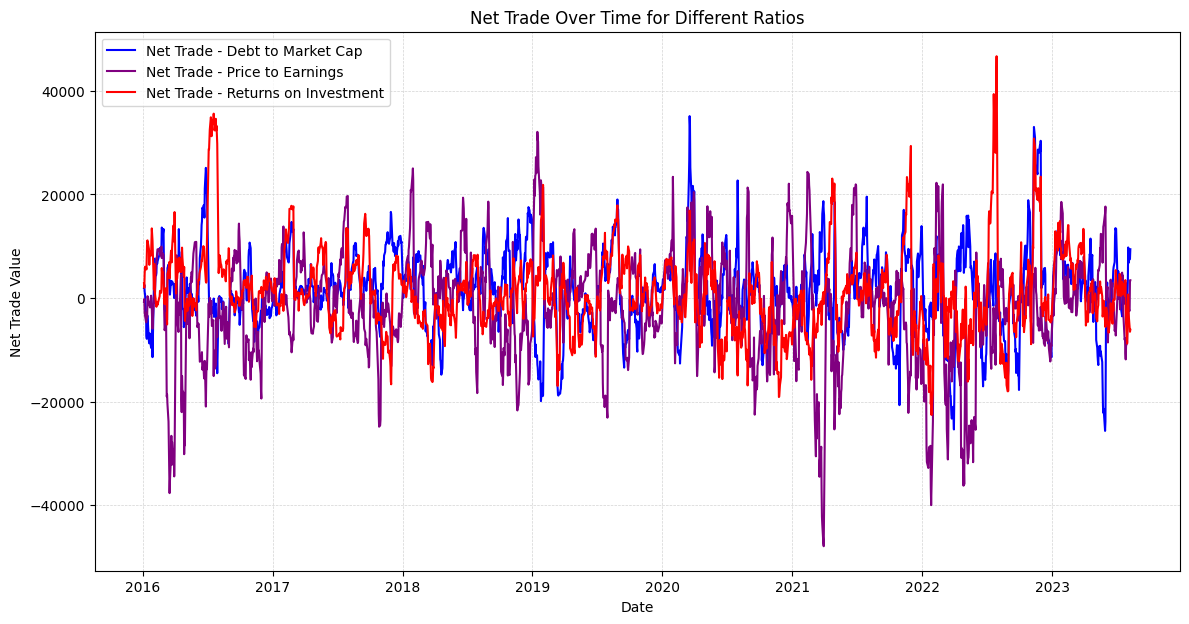

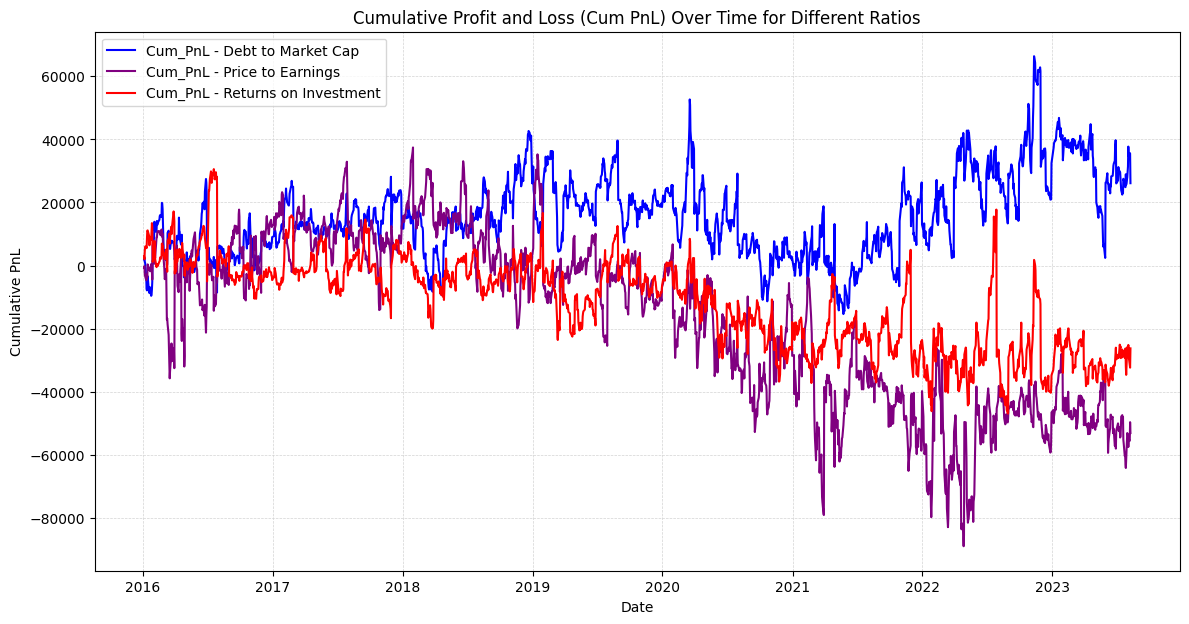

In [842]:
# Plotting the Unrealized results
plot_metric(unrealized_pnl_dtm.dropna(), unrealized_pnl_pte.dropna(), unrealized_pnl_roi.dropna(), 'Net Trade', 'Net Trade Over Time for Different Ratios', 'Net Trade Value')
plot_metric(unrealized_pnl_dtm.dropna(), unrealized_pnl_pte.dropna(), unrealized_pnl_roi.dropna(), 'Cum_PnL', 'Cumulative Profit and Loss (Cum PnL) Over Time for Different Ratios', 'Cumulative PnL')


The graph shows the cumulative profit and loss (Cum PnL) for three different trading strategies over time. From the graph, we can observe that the  **Debt to Market Cap** appears to be the most successful strategy in terms of cumulative PnL over the period shown. The line representing this strategy (in blue) shows higher peaks and less pronounced troughs compared to the other strategies, indicating a potentially higher and more stable return.

The **Price to Earnings** (red line) experiences significant volatility, with sharp rises and falls. This suggests that the strategy might have periods of strong performance followed by significant downturns. And finally, the **Returns on Investment** (purple line) has the lowest cumulative PnL over the period, indicating that this strategy might be the least profitable of the three. It also appears to have the most pronounced downward trend post-2021.

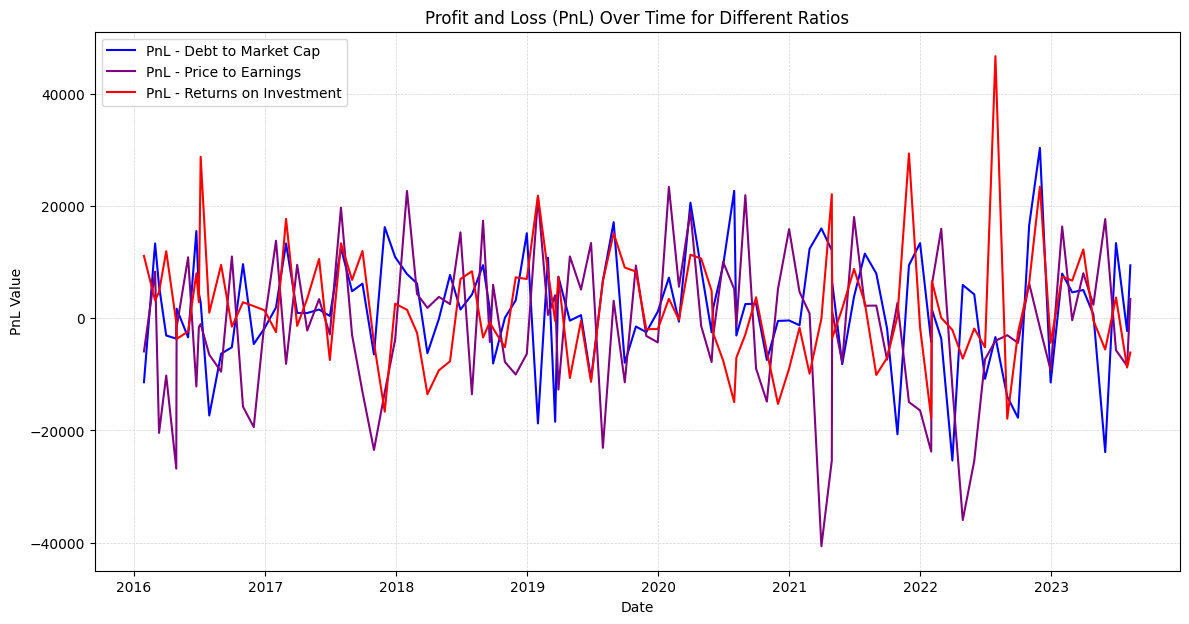

In [843]:
# Plotting the OnL results
plot_metric(realized_pnl_dtm.dropna(), realized_pnl_pte.dropna(), realized_pnl_roi.dropna(), 'PnL', 'Profit and Loss (PnL) Over Time for Different Ratios', 'PnL Value')

The graph shows the Profit and Loss (PnL) over time for the same three strategies based on different financial ratios. All three strategies show significant volatility in their PnL values over time, with none of the strategies consistently outperforming the others throughout the entire period.
Regarding the peak Performances it is achieved by the Returns on Investment ratio strategy, spiking above $40,000 in the second half of 2022, indicating a period of high profitability and the lowest Performanceis achieved by Price to Earnings ratio strategy that drops below negative $40,000 in the first half of 2021, signifying a substantial loss during that time.

**Implement a combination of the previous ratios**

In this part of the project, we want to seek a combination of the three ratios computed previously. In order to achieve this combination the statistical tool **zscore** has been implemented. This tool computes the z-score of each value inthe sample, relative to the sample mean and standard deviation. 

In [844]:
from scipy.stats import zscore

The `get_z_score` function has been designed to calculate the z-scores (standard score) for each column specified in `sort_by` within the given `data`, then sums these scores to create a 'total_zscore' for each row.

In [845]:
def get_z_score(data, sort_by):
    temp = data.loc[:,sort_by].apply(zscore)
    data['total_zscore'] =  temp.sum(axis=1, min_count=1)
    return data.sort_values('total_zscore', ascending = True)

This strategy is very similar to the one implemented before, however this time the get_z_score function is included within the `get_quantile_strategy_combination(combination_list, Notional)` function. 

In [846]:
# Strategy Combination

def get_start_and_end_dates(data, date_column, group_columns):
    """
    Get start and end dates for each ticker and month.
    """
    data[date_column] = pd.to_datetime(data[date_column])
    start_dates = data.groupby(group_columns)[date_column].min()
    end_dates = data.groupby(group_columns)[date_column].max()

    return np.array(start_dates.unique()), np.array(end_dates.unique())

import pandas as pd

def calculate_positions(data, tickers, date_key, Notional):
    position = data[data.ticker.isin(tickers)].loc[date_key].reset_index().drop_duplicates().set_index(['date','ticker'])
    position = position.unstack()
    position = position.sum(axis=1)
    shares = (Notional / 2) / position[0]

    return position * shares

def calculate_pnl(long_position, short_position, trading_days):
    unrealized = pd.DataFrame()
    unrealized['Long Positions'] = long_position
    unrealized['Short Positions'] = short_position
    unrealized['Net Trade'] = unrealized['Long Positions'] - unrealized['Short Positions']
    unrealized['PnL'] = unrealized['Net Trade'].diff()
    unrealized['PnL'].iloc[-1] = - unrealized['Net Trade'].iloc[-1]

    realized = unrealized[unrealized.index.isin(trading_days)]
    realized['PnL'] = realized['Net Trade'].diff()

    return realized, unrealized

def get_quantile_strategy_combination(combination_list, Notional):
    
    Initial_capital = Notional*10
    funding_rate = 1.5 #(assuming constant 1.5% funding rate)
    repo_rate = 1 #(funding rate - 100bps)

    start_dates, end_dates = get_start_and_end_dates(filtered_merged_data, 'date', ['ticker', 'year_month'])
    trading_days = np.concatenate((end_dates, start_dates))
    trading_days = pd.to_datetime(trading_days)  
    trading_days = np.sort(trading_days) 

    # Each ratios calculated as input for column 
    ratio_column = filtered_merged_data.copy()
    ratio_column.set_index('ticker', inplace=True)
    ratio_column = ratio_column[['date','debt_to_market_cap','Returns_On_Inv', 'Price_To_Earnings']]
    ratio_column = ratio_column[ratio_column.date.isin(start_dates)].reset_index().set_index('date')

    prices_strat = filtered_merged_data.copy()
    prices_strat.set_index('ticker', inplace=True)
    prices_strat = prices_strat[['date', 'adj_close']].reset_index().set_index('date') 
    
    # Initialize empty DataFrames for realized and unrealized PnL
    realized_final = pd.DataFrame()
    unrealized_final = pd.DataFrame()

    for i in filtered_merged_data.year_month.unique():
        z_data = get_z_score(ratio_column.loc[i].reset_index(drop = True),sort_by = combination_list)
        
        top_20_tickers = z_data.ticker[:20]
        long_position = calculate_positions(prices_strat, top_20_tickers, i, Notional)

        bottom_20_tickers = z_data.ticker[:-20]
        short_position = calculate_positions(prices_strat, bottom_20_tickers, i, Notional)

        realized_PnL, unrealized_PnL = calculate_pnl(long_position, short_position, trading_days)
        
        Notional = Notional * repo_rate + realized_PnL.PnL[-1]

        unrealized_final = pd.concat([unrealized_final,unrealized_PnL])
        realized_final = pd.concat([realized_final,realized_PnL])

    unrealized_final['Cum_PnL'] = unrealized_final['PnL'].cumsum()
    return realized_final, unrealized_final
    

Applying the new strategy and plotting the results

In [847]:
realized_pnl_comb, unrealized_pnl_comb = get_quantile_strategy_combination(['debt_to_market_cap','Returns_On_Inv', 'Price_To_Earnings'],1000000)

The `plot_metric_comb` function has been designed to graph the information from multiple datasets in a single plot. This function will be used to plot the realized and unrealized returns. 

In [848]:
def plot_metric_comb(dtm, pte, roi, comb, column, title, ylabel):
    plt.figure(figsize=(14, 7))
    plt.plot(dtm.index, dtm[column], label='Debt to Market Cap', color='blue')
    plt.plot(pte.index, pte[column], label='Price to Earnings', color='purple')
    plt.plot(roi.index, roi[column], label='Returns on Investment', color='red')
    plt.plot(comb.index, comb[column], label='Combination', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
    plt.show()

**Combine All Unrealized ratios**

From the unrealized table, we will split the data into two new dataframes. These dataframes will ensamble the information of the three ratios for a better comparison of the obtained results. 

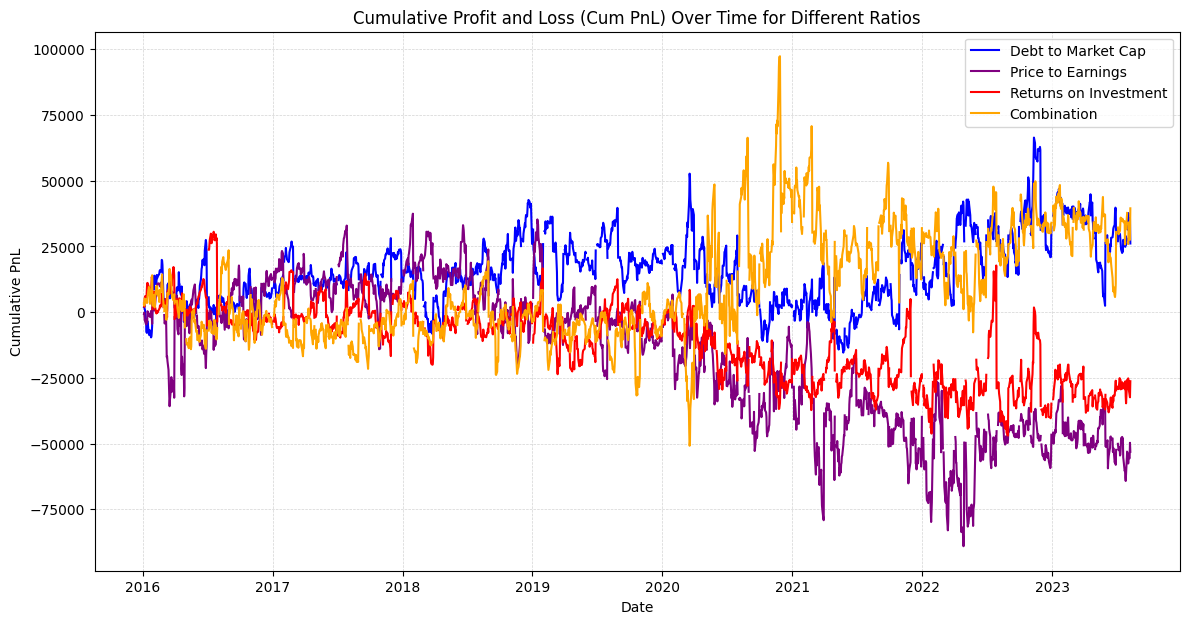

In [849]:
unrealized_table_cumPnL = pd.DataFrame()
unrealized_table_cumPnL["debt_to_market_cap"] = unrealized_pnl_dtm['Cum_PnL'].dropna()
unrealized_table_cumPnL["Price_To_Earnings"] = unrealized_pnl_pte['Cum_PnL'].dropna()
unrealized_table_cumPnL["Returns_On_Inv"] = unrealized_pnl_roi['Cum_PnL'].dropna()
unrealized_table_cumPnL["Combination"] = unrealized_pnl_comb['Cum_PnL'].dropna()
unrealized_table_cumPnL.head()

plot_metric_comb(unrealized_pnl_dtm, unrealized_pnl_pte, unrealized_pnl_roi, unrealized_pnl_comb, 'Cum_PnL', 'Cumulative Profit and Loss (Cum PnL) Over Time for Different Ratios', 'Cumulative PnL')

The graph shows the cumulative profit and loss (Cum PnL) over time for four different investment strategies. Different to the previous cumulative profit and loss (Cum PnL) graph, in this one the combination line has been added, this combination is just an aggregation using all three ratios. Overall, each strategy exhibits its own pattern and level of volatility, with the Combination strategy occasionally outperforming the individual ratio strategies

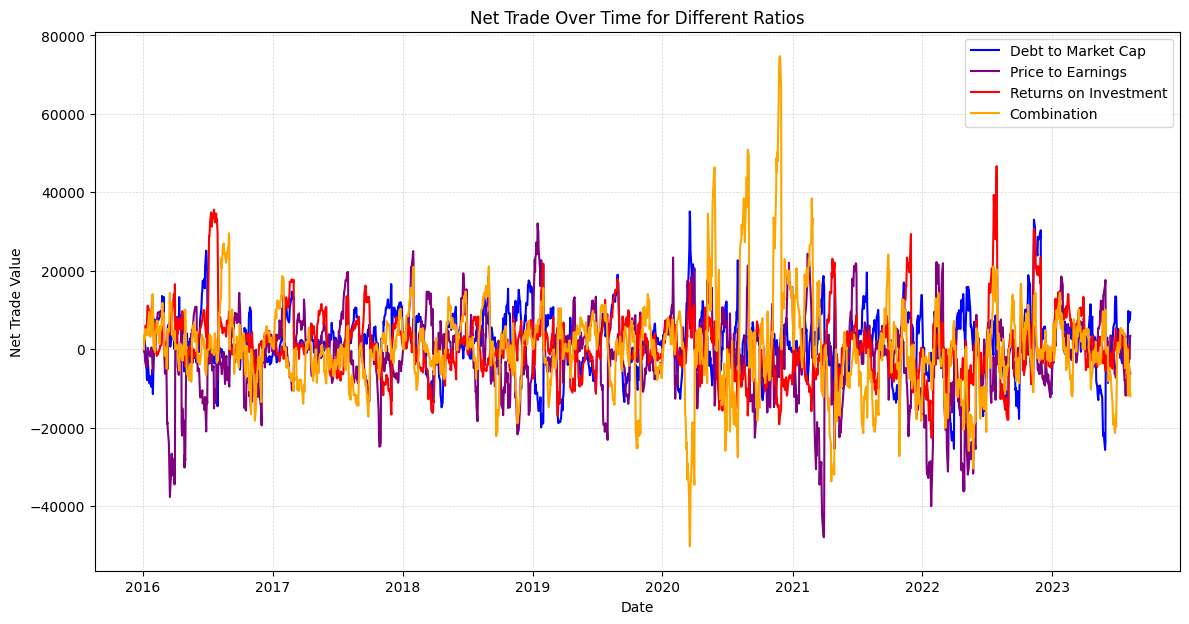

In [850]:
unrealized_table_nettrade = pd.DataFrame()
unrealized_table_nettrade["debt_to_market_cap"] = unrealized_pnl_dtm['Net Trade'].dropna()
unrealized_table_nettrade["Price_To_Earnings"] = unrealized_pnl_pte['Net Trade'].dropna()
unrealized_table_nettrade["Returns_On_Inv"] = unrealized_pnl_roi['Net Trade'].dropna()
unrealized_table_nettrade["Combination"] = unrealized_pnl_comb['Net Trade'].dropna()
unrealized_table_nettrade.head()

plot_metric_comb(unrealized_pnl_dtm, unrealized_pnl_pte, unrealized_pnl_roi, unrealized_pnl_comb, 'Net Trade', 'Net Trade Over Time for Different Ratios', 'Net Trade Value')

**Combine All Realized ratios**

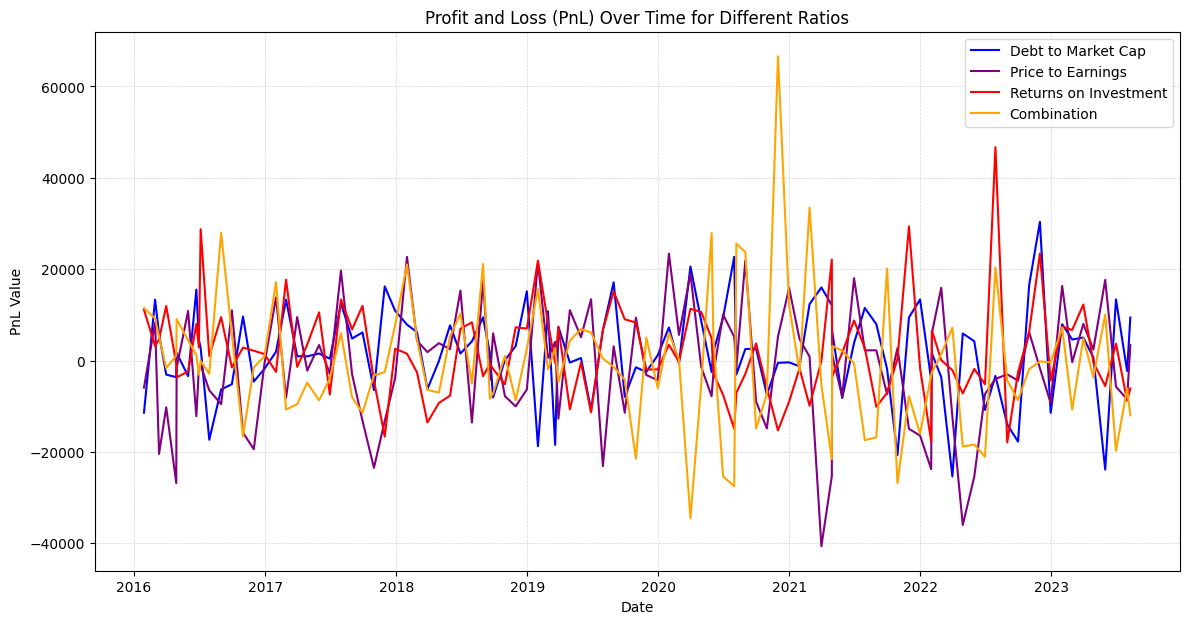

In [851]:
realized_table_PnL = pd.DataFrame()
realized_table_PnL["debt_to_market_cap"] = realized_pnl_dtm['PnL'].dropna()
realized_table_PnL["Price_To_Earnings"] = realized_pnl_pte['PnL'].dropna()
realized_table_PnL["Returns_On_Inv"] = realized_pnl_roi['PnL'].dropna()
realized_table_PnL["Combination"] = realized_pnl_comb['PnL'].dropna()
realized_table_PnL.head()

plot_metric_comb(realized_pnl_dtm.dropna(), realized_pnl_pte.dropna(), realized_pnl_roi.dropna(), realized_pnl_comb.dropna(), 'PnL', 'Profit and Loss (PnL) Over Time for Different Ratios', 'PnL Value')

The graph illustrates the Profit and Loss (PnL) values over time for four investment strategies. It shows the fluctuating profitability of each strategy from 2016 to 2023. The strategies appear to have periods of significant gains and losses, with the PnL values rising above $40,000 (Returns on Investments) and dipping below -$40,000 at times as well (Price to Earnings). However, this time we have included the Combination strategy, that shows moments that leads in performance, specially when it rises above $60,000. 

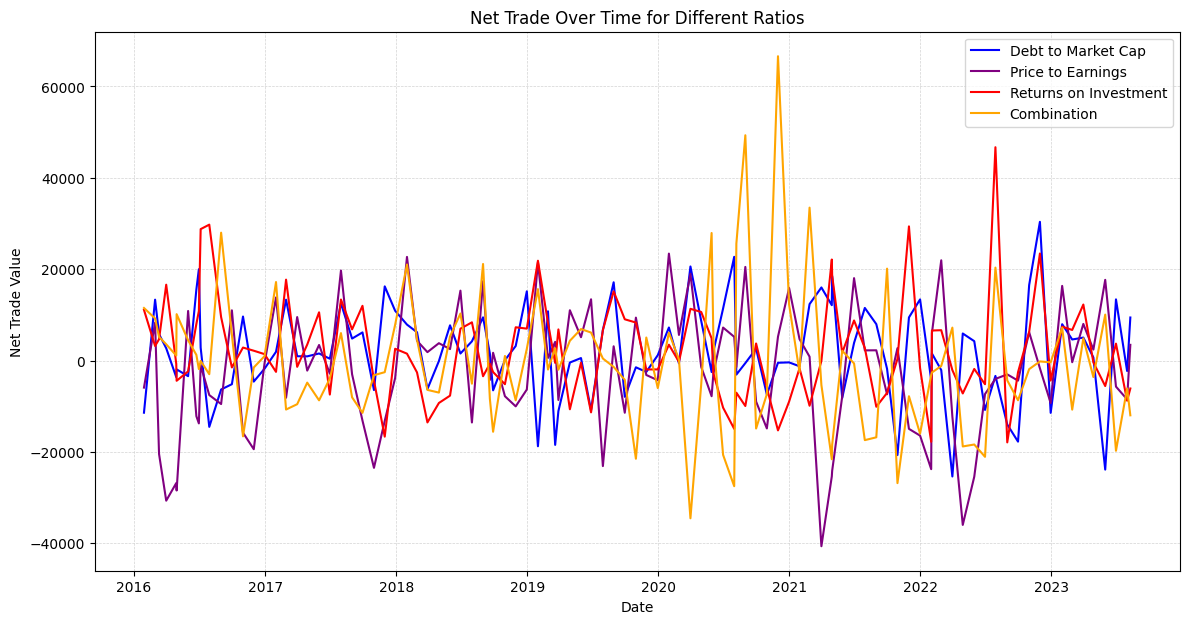

In [852]:
realized_table_nettrade = pd.DataFrame()
realized_table_nettrade["debt_to_market_cap"] = realized_pnl_dtm['Net Trade'].dropna()
realized_table_nettrade["Price_To_Earnings"] = realized_pnl_pte['Net Trade'].dropna()
realized_table_nettrade["Returns_On_Inv"] = realized_pnl_roi['Net Trade'].dropna()
realized_table_nettrade["Combination"] = realized_pnl_comb['Net Trade'].dropna()
realized_table_nettrade.head()

plot_metric_comb(realized_pnl_dtm.dropna(), realized_pnl_pte.dropna(), realized_pnl_roi.dropna(), realized_pnl_comb.dropna(), 'Net Trade', 'Net Trade Over Time for Different Ratios', 'Net Trade Value')

**Compute Returns for all the 3 individual ratios**

In [853]:
Notional = 100000
Initial_capital = Notional*10

The`realized_table_returns` DataFrame contains the realized percentage returns of four trading strategies by dividing the Profit and Loss (PnL) by the `Initial_capital` and multiplying by 100. This table will be used to compute metrics such as Sharpe Ratio, max_drawdown or cumulative returns. 

In [854]:
realized_table_returns = pd.DataFrame()
realized_table_returns["debt_to_market_cap"] = realized_pnl_dtm['PnL'].dropna()/Initial_capital*100
realized_table_returns["Price_To_Earnings"] = realized_pnl_pte['PnL'].dropna()/Initial_capital*100
realized_table_returns["Returns_On_Inv"] = realized_pnl_roi['PnL'].dropna()/Initial_capital*100
realized_table_returns["Combination"] = realized_pnl_comb['PnL'].dropna()/Initial_capital*100
realized_table_returns.head()

,debt_to_market_cap,Price_To_Earnings,Returns_On_Inv,Combination
date,,,,
2016-01-29,-1.141242,-0.592043,1.108785,1.150605
2016-02-29,1.332537,0.829413,0.318737,0.921391
2016-03-11,0.577897,-2.043745,0.466070,0.520938
2016-03-31,-0.308276,-1.022820,1.194091,-0.165160
2016-04-28,-0.363854,-2.680646,-0.073551,0.109318


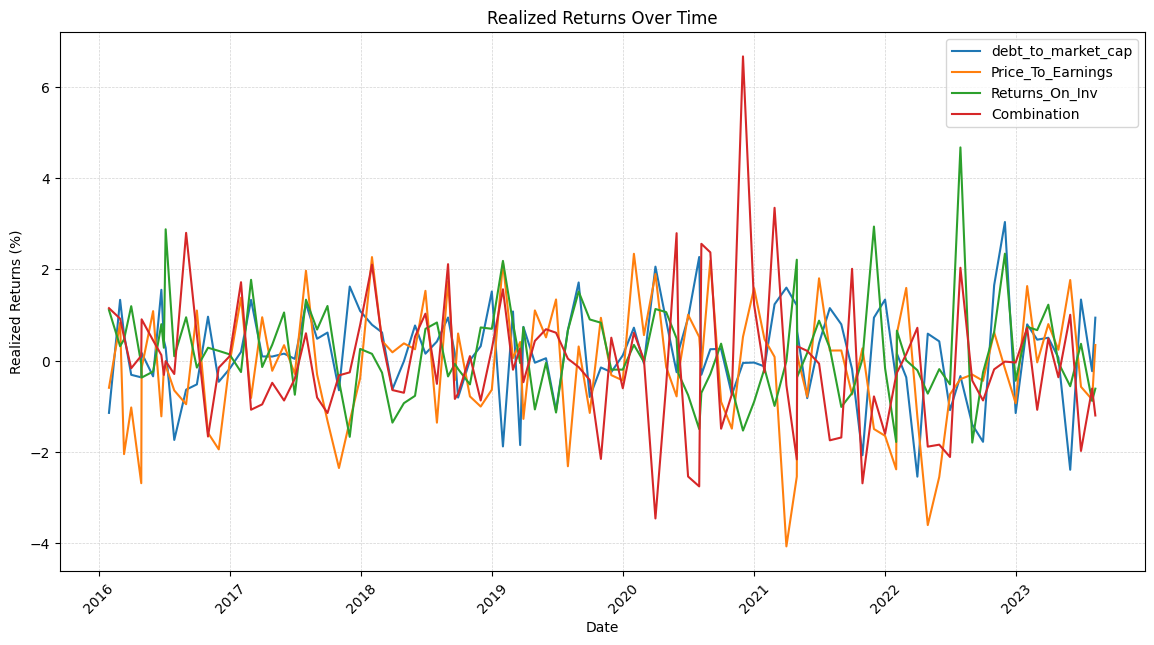

In [855]:
plt.figure(figsize=(14, 7))

for column in realized_table_returns.columns:
    plt.plot(realized_table_returns.index, realized_table_returns[column], label=column)

plt.title('Realized Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Realized Returns (%)')

plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

The `calculate_sharpe_ratio` function computes the Sharpe Ratio, a measure of risk-adjusted return, by annualizing the mean of excess returns over the risk-free rate divided by the standard deviation of the excess returns.

The `calculate_max_drawdown`function determines the maximum drawdown, which is the largest peak-to-trough decline in the cumulative returns of a strategy, indicating the potential risk from a high to a low point.

The `calculate_cumulative_returns` function calculates the cumulative returns of a strategy by compounding daily returns over time, showing the aggregate effect of the returns on investment.

The `pl_to_traded_notional_ratio` function calculates the ratio of profit and loss (P&L) to the traded notional amount, reflecting the efficiency of the strategy in terms of the returns generated per unit of capital traded.

In [856]:
repo_rate = 1

def calculate_sharpe_ratio(returns, repo_rate):
    """
    Calculates Sharpe Ratio of a strategy.
    """
    rf_daily = (1 + repo_rate) ** (1/252) - 1 # Compounded daily risk-free rate
    excess_returns = returns - rf_daily
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    return sharpe_ratio

def calculate_max_drawdown(cumulative_returns):
    """
    Calculates the Maximum Drawdown of a strategy.
    """
    drawdown = cumulative_returns.div(cumulative_returns.cummax()) - 1
    max_drawdown = drawdown.min()
    return max_drawdown

def calculate_cumulative_returns(daily_returns):
    """
    Calculates Cumulative Returns from daily returns.
    """
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    return cumulative_returns

def pl_to_traded_notional_ratio(pl, Notional):
    """
    Calculate the PL to Traded Notional Ratio.
    """
    return pl.sum() / Notional


In [857]:
performance_metrics = pd.DataFrame(index=['Sharpe Ratio', 'Max Drawdown', 'Cumulative Return', 'PnL to Notional Ratio'])

for column in realized_table_returns.columns:
    daily_returns = realized_table_returns[column]
    cumulative_returns = calculate_cumulative_returns(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns, repo_rate)
    max_drawdown = calculate_max_drawdown(cumulative_returns)
    pl_ratio = pl_to_traded_notional_ratio(realized_table_PnL[column], Notional)
    
    performance_metrics[column] = [sharpe_ratio, max_drawdown, cumulative_returns.iloc[-1], pl_ratio]

performance_metrics = performance_metrics.round(3)
performance_metrics

,debt_to_market_cap,Price_To_Earnings,Returns_On_Inv,Combination
Sharpe Ratio,2.927,-1.938,2.715,-0.483
Max Drawdown,-15.974,0.000,-1.542,-2.717
Cumulative Return,2093.844,-1.000,-1.000,-1.000
PnL to Notional Ratio,1.907,-1.571,1.825,-0.413


The **Sharpe Ratio** indicates the risk-adjusted return. A higher Sharpe Ratio suggests a better return for the same level of risk. Here, the 'debt to market cap' strategy has a high positive Sharpe Ratio, suggesting strong risk-adjusted returns, while 'Price To Earnings' has a negative Sharpe Ratio, indicating a poor return for the level of risk taken.

Regarding the **Max Drawdown** metric, it reflects the largest single drop from peak to trough during the investment period. The 'Price To Earnings' strategy shows a max drawdown of 0.00%, which might indicate that there were no drawdowns or negative returns. The 'debt to market cap' strategy has a max drawdown of about -15.97%, indicating that at its worst point, the cumulative return dropped by this percentage from its peak.

The **Cumulative Return** shows the total percentage gain or loss over the investment period. A value over 100% indicates a profit, while a negative value indicates a loss. The 'debt to market cap' strategy shows a very high cumulative return, while the other strategies show a cumulative return of -100%, which suggests a complete loss of the initial investment.

Finally, the **PnL to Notional Ratio** indicates how much profit or loss was made relative to the total amount of capital traded. Positive values indicate a profit, and negative values indicate a loss relative to the notional. Here, 'debt to market cap' and 'Returns_On_Inv' have a positive ratio, showing efficiency in capital use, whereas 'Price To Earnings' and 'Combination' have negative ratios, indicating losses.